In [1]:
# Imports
import pandas as pd
import numpy as np
import os

# Preprocessing

In [2]:
# Load df

team_id = '20' #put your team id here
split = 'test_1' # replace by 'test_2' for FINAL submission

df = pd.read_csv('dataset/tweets_train.csv')
df_test = pd.read_csv(f'dataset/tweets_{split}.csv')

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2023-08-09 13:52:39.480988: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 13:52:40.185111: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# # Converting the "words" column from string representation to actual lists
# import ast
# df['words_list'] = df['words'].apply(ast.literal_eval)

# # Displaying the first few entries in the "words_list" column
# df['words_list'].head()

In [5]:
# from keras.preprocessing.sequence import pad_sequences

# # Building a vocabulary by assigning a unique integer to each word
# vocab = {word: idx + 1 for idx, word in enumerate(set(word for words in df['words_list'] for word in words))}

# # Transforming the words into sequences of integers
# sequences = [[vocab[word] for word in words] for words in df['words_list']]

# # Padding the sequences to make them of the same length
# padded_sequences = pad_sequences(sequences, padding='post')

# # Displaying the shape of the padded sequences
# padded_sequences.shape


In [6]:
# from sklearn.preprocessing import LabelEncoder

# # Encoding the target variable (sentiment)
# label_encoder = LabelEncoder()
# encoded_labels = label_encoder.fit_transform(df['sentiment'])

# # Displaying the unique classes and their corresponding encoded values
# label_mapping = {label: idx for idx, label in enumerate(label_encoder.classes_)}
# label_mapping, encoded_labels[:5]


In [7]:
# from sklearn.model_selection import train_test_split

# # Splitting the data into training and validation sets (80% training, 20% validation)
# X_train, X_val, y_train, y_val = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

# # Displaying the shape of the training and validation sets
# X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Concatenate the words in the 'words_list' column to create sentences
df['sentences'] = df['words'].apply(lambda words: ' '.join(eval(words)))
df_test['sentences'] = df_test['words'].apply(lambda words: ' '.join(eval(words)))

# Initialize the tokenizer with a specific vocabulary size
vocab_size = 500000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['sentences'])

# Transform the text into sequences of integers
sequences = tokenizer.texts_to_sequences(df['sentences'])

# Pad the sequences to make them of the same length
padded_sequences = pad_sequences(sequences, padding='post')

# Encode the target variable (sentiment)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['sentiment'])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

# Display the shape of the training and validation sets
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


max_length = X_train.shape[1]

(6400, 38) (1600, 38) (6400,) (1600,)


# Classification

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import regularizers
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping


In [10]:
from keras.initializers import RandomNormal

initializer_rand_nor = RandomNormal(mean=0.0, stddev=0.05, seed=42)

from keras.initializers import RandomUniform

initializer_rand_unf = RandomUniform(minval=-0.05, maxval=0.05, seed=42)

from keras.initializers import Zeros

initializer_zero = Zeros()

from keras.initializers import Ones

initializer_one = Ones()

from keras.initializers import glorot_uniform

initializer_glorot = glorot_uniform(seed=42)

from keras.initializers import he_normal

initializer_he = he_normal(seed=42)

In [11]:
# Define the LSTM model
vocab_size = 500000
embedding_dim = 50

# If you have a specific regularization value in mind (e.g., L1 or L2), you can define it as follows:
regularise = regularizers.l2(0.01)

model = Sequential([
    Embedding(vocab_size, 128, input_length=max_length),
    Dropout(0.5),
    LSTM(32,kernel_constraint=max_norm(3)),
    Dense(32,activation='relu'),
    Dropout(0.5),
    Dense(3,activation='softmax'),
])


2023-08-09 13:52:42.162863: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 13:52:42.180255: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 13:52:42.180508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [12]:
from tensorflow.keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train, num_classes=3)
y_val_one_hot = to_categorical(y_val, num_classes=3)

In [13]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

class_weights = compute_class_weight('balanced', classes=[0, 1, 2], y=y_train)
class_weights = {i: weight for i, weight in enumerate(class_weights)}
# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)


# Train the model with the early stopping callback
history = model.fit(X_train, y_train_one_hot, 
                    validation_data=(X_val, y_val_one_hot), 
                    epochs=30, 
                    batch_size=32)



Epoch 1/30


2023-08-09 13:52:45.385396: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8900
2023-08-09 13:52:45.508141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-09 13:52:45.510003: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7663fcb100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-09 13:52:45.510029: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-08-09 13:52:45.516914: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-09 13:52:45.650404: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

200/200 [==============================] - 24s 104ms/step - loss: 0.8552 - accuracy: 0.6352 - val_loss: 0.7711 - val_accuracy: 0.6812
Epoch 2/30
200/200 [==============================] - 8s 40ms/step - loss: 0.8146 - accuracy: 0.6580 - val_loss: 0.6798 - val_accuracy: 0.7306
Epoch 3/30
200/200 [==============================] - 4s 19ms/step - loss: 0.5842 - accuracy: 0.7783 - val_loss: 0.6010 - val_accuracy: 0.7862
Epoch 4/30
200/200 [==============================] - 3s 15ms/step - loss: 0.3866 - accuracy: 0.8786 - val_loss: 0.6729 - val_accuracy: 0.7819
Epoch 5/30
200/200 [==============================] - 3s 14ms/step - loss: 0.2841 - accuracy: 0.9058 - val_loss: 0.7138 - val_accuracy: 0.8019
Epoch 6/30
200/200 [==============================] - 3s 14ms/step - loss: 0.2067 - accuracy: 0.9388 - val_loss: 0.8596 - val_accuracy: 0.7962
Epoch 7/30
200/200 [==============================] - 2s 12ms/step - loss: 0.1531 - accuracy: 0.9570 - val_loss: 1.0070 - val_accuracy: 0.7894
Epoch 8/

50/50 [==============================] - 0s 2ms/step


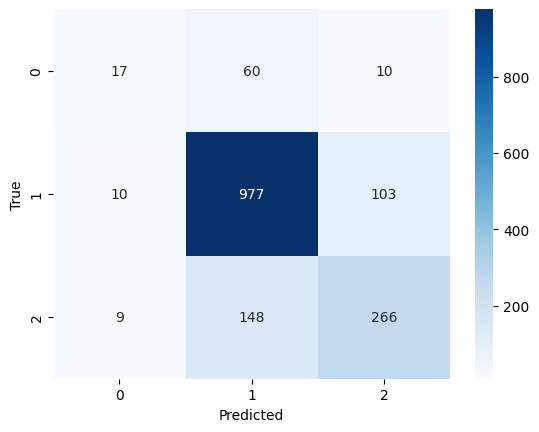

In [14]:
# Evaluate the model on validation data
val_predictions = model.predict(X_val).argmax(axis=1)
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_val, val_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [15]:
print(classification_report(y_val, val_predictions))

              precision    recall  f1-score   support

           0       0.47      0.20      0.28        87
           1       0.82      0.90      0.86      1090
           2       0.70      0.63      0.66       423

    accuracy                           0.79      1600
   macro avg       0.67      0.57      0.60      1600
weighted avg       0.77      0.79      0.78      1600



# Model 2

In [16]:
# Define the vocabulary size
vocab_size = 500000

# Build the model
model2 = Sequential([
    Embedding(vocab_size, 128, input_length=max_length),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax'),
])

# Compile the model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Fit the model
history2 = model2.fit(X_train, y_train_one_hot, epochs=30, validation_split=0.2)

Epoch 1/30
160/160 [==============================] - 19s 95ms/step - loss: 0.8519 - accuracy: 0.6297 - val_loss: 0.7182 - val_accuracy: 0.6727
Epoch 2/30
160/160 [==============================] - 7s 45ms/step - loss: 0.6010 - accuracy: 0.7752 - val_loss: 0.6214 - val_accuracy: 0.7641
Epoch 3/30
160/160 [==============================] - 4s 26ms/step - loss: 0.3000 - accuracy: 0.9055 - val_loss: 0.7107 - val_accuracy: 0.7492
Epoch 4/30
160/160 [==============================] - 3s 18ms/step - loss: 0.1193 - accuracy: 0.9656 - val_loss: 1.0260 - val_accuracy: 0.7523
Epoch 5/30
160/160 [==============================] - 3s 19ms/step - loss: 0.0535 - accuracy: 0.9873 - val_loss: 1.4545 - val_accuracy: 0.7453
Epoch 6/30
160/160 [==============================] - 4s 22ms/step - loss: 0.0363 - accuracy: 0.9916 - val_loss: 1.5186 - val_accuracy: 0.7430
Epoch 7/30
160/160 [==============================] - 3s 17ms/step - loss: 0.0292 - accuracy: 0.9916 - val_loss: 1.8406 - val_accuracy: 0.754

50/50 [==============================] - 1s 4ms/step


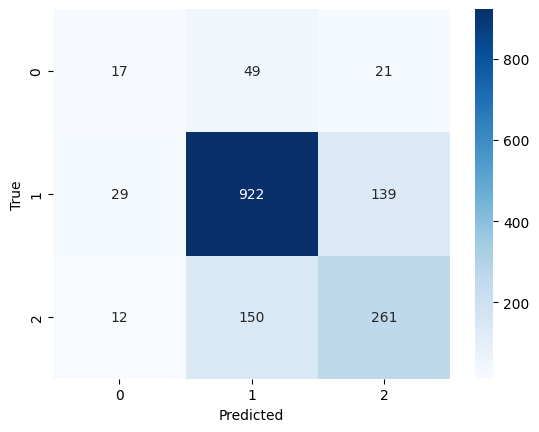

In [17]:
# Evaluate the model on validation data
val_predictions = model2.predict(X_val).argmax(axis=1)
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_val, val_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [18]:
print(classification_report(y_val, val_predictions))

              precision    recall  f1-score   support

           0       0.29      0.20      0.23        87
           1       0.82      0.85      0.83      1090
           2       0.62      0.62      0.62       423

    accuracy                           0.75      1600
   macro avg       0.58      0.55      0.56      1600
weighted avg       0.74      0.75      0.74      1600



# Model 3

In [19]:
# Define the LSTM model
vocab_size = 500000
embedding_dim = 50

model3 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(3, activation='softmax'),
])
# Compile the model
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [20]:
# Train the model
history3 = model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32)

Epoch 1/30


200/200 [==============================] - 24s 107ms/step - loss: 0.8229 - accuracy: 0.6528 - val_loss: 0.7701 - val_accuracy: 0.6812
Epoch 2/30
200/200 [==============================] - 8s 38ms/step - loss: 0.6602 - accuracy: 0.7398 - val_loss: 0.6357 - val_accuracy: 0.7494
Epoch 3/30
200/200 [==============================] - 3s 16ms/step - loss: 0.3040 - accuracy: 0.8973 - val_loss: 0.6192 - val_accuracy: 0.7738
Epoch 4/30
200/200 [==============================] - 3s 14ms/step - loss: 0.1302 - accuracy: 0.9605 - val_loss: 0.8809 - val_accuracy: 0.7694
Epoch 5/30
200/200 [==============================] - 3s 17ms/step - loss: 0.0720 - accuracy: 0.9800 - val_loss: 0.8744 - val_accuracy: 0.7694
Epoch 6/30
200/200 [==============================] - 3s 15ms/step - loss: 0.0465 - accuracy: 0.9870 - val_loss: 0.9097 - val_accuracy: 0.7681
Epoch 7/30
200/200 [==============================] - 2s 8ms/step - loss: 0.0332 - accuracy: 0.9922 - val_loss: 1.1341 - val_accuracy: 0.7594
Epoch 8/3

50/50 [==============================] - 1s 2ms/step


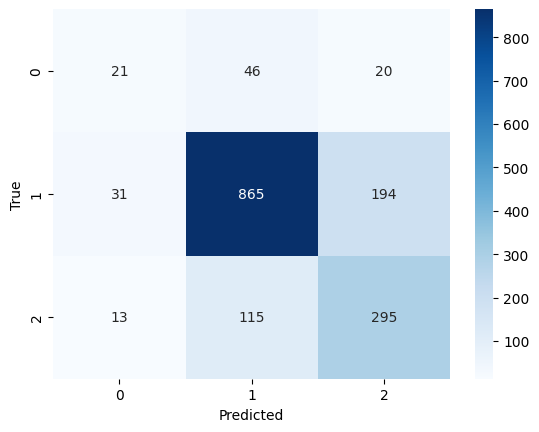

In [21]:
# Evaluate the model on validation data
val_predictions = model3.predict(X_val).argmax(axis=1)
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_val, val_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [22]:
print(classification_report(y_val, val_predictions))

              precision    recall  f1-score   support

           0       0.32      0.24      0.28        87
           1       0.84      0.79      0.82      1090
           2       0.58      0.70      0.63       423

    accuracy                           0.74      1600
   macro avg       0.58      0.58      0.58      1600
weighted avg       0.75      0.74      0.74      1600



# Test


In [27]:
# Assuming the 'words' column contains lists of words
words_test = list(df_test.sentences)

# Convert the words to sequences of integers using your existing tokenizer
X_test_sequences = tokenizer.texts_to_sequences(words_test)

# Pad the sequences to the same length as your training data
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length)

# Predict the probabilities for each class
y_prob = model.predict(X_test_padded)

# Take the class with the highest probability
y_hat = np.argmax(y_prob, axis=1)

# If you used LabelEncoder to encode the labels, you can reverse transform
# the numerical labels back to the original form
y_hat = label_encoder.inverse_transform(y_hat)

# Create directory if not exists
directory = 'lstm_results'
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the results with the format <TEAM_ID>__<SPLIT>_clf_pred.npy
np.save(os.path.join(directory, f'{team_id}__{split}__clf_pred.npy'), y_hat)


32/32 [==============================] - 0s 2ms/step


In [24]:
# Load 20__test_1__clf_pred.npy

np.load('lstm_results/20__test_1__clf_pred.npy', allow_pickle=True)

array(['neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'positive', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral',